# Analyze and classify images (SVM vs MLP comparison)

In [1]:
# Created by Jesús García García - Master´s Degree in Big Data Analytics UEM

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 20 18:00:00 2018

@author: Jesús García
"""
#Import libraries
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


# Display progress logs on stdout
print("Put info to DEBUG for getting all useful information  ")
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(message)s')
# I can choose between:  DEBUG - INFO - WARNING - ERROR - CRITICAL


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays
print("Download if it isn´t saved on HD... ")
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)


# Introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# For machine learning we use the 2 data directly (as relative pixel
# Positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# The label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Put info to DEBUG for getting all useful information  
Download if it isn´t saved on HD... 
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [3]:
# Split into a training set and a test set using a stratified k fold
#Train and Test. Use SciKit Learn to create training and testing sets of the data


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)
#original >>> random_state=42)
#Source about random state, why ever same faces: https://stackoverflow.com/questions/28064634/random-state-pseudo-random-numberin-scikit-learn

# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a classification model (MLP, SVM)
print("Train a classification model (MLP, SVM)")
t0 = time()
param_grid_MLP = {'alpha': [1e-3, 5e-3, 1e-4, 5e-4, 1e-5],
              'hidden_layer_sizes': [(90,90),(20,20),(30,30)], }
clf_MLP = GridSearchCV(MLPClassifier(), param_grid_MLP)
clf_MLP = clf_MLP.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_MLP.best_estimator_)


print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Extracting the top 150 eigenfaces from 966 faces
done in 0.132s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.013s
Train a classification model (MLP, SVM)


C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklea

done in 26.250s
Best estimator found by grid search:
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(90, 90), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Fitting the classifier to the training set
done in 23.919s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


SVM  PREDICTING   
Predicting people's names on the test set
done in 0.061s
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.75      0.86        20
     Colin Powell       0.87      0.83      0.85        64
  Donald Rumsfeld       0.95      0.81      0.88        26
    George W Bush       0.80      0.96      0.87       136
Gerhard Schroeder       0.91      0.74      0.82        27
      Hugo Chavez       0.90      0.56      0.69        16
       Tony Blair       0.93      0.79      0.85        33

      avg / total       0.87      0.85      0.85       322



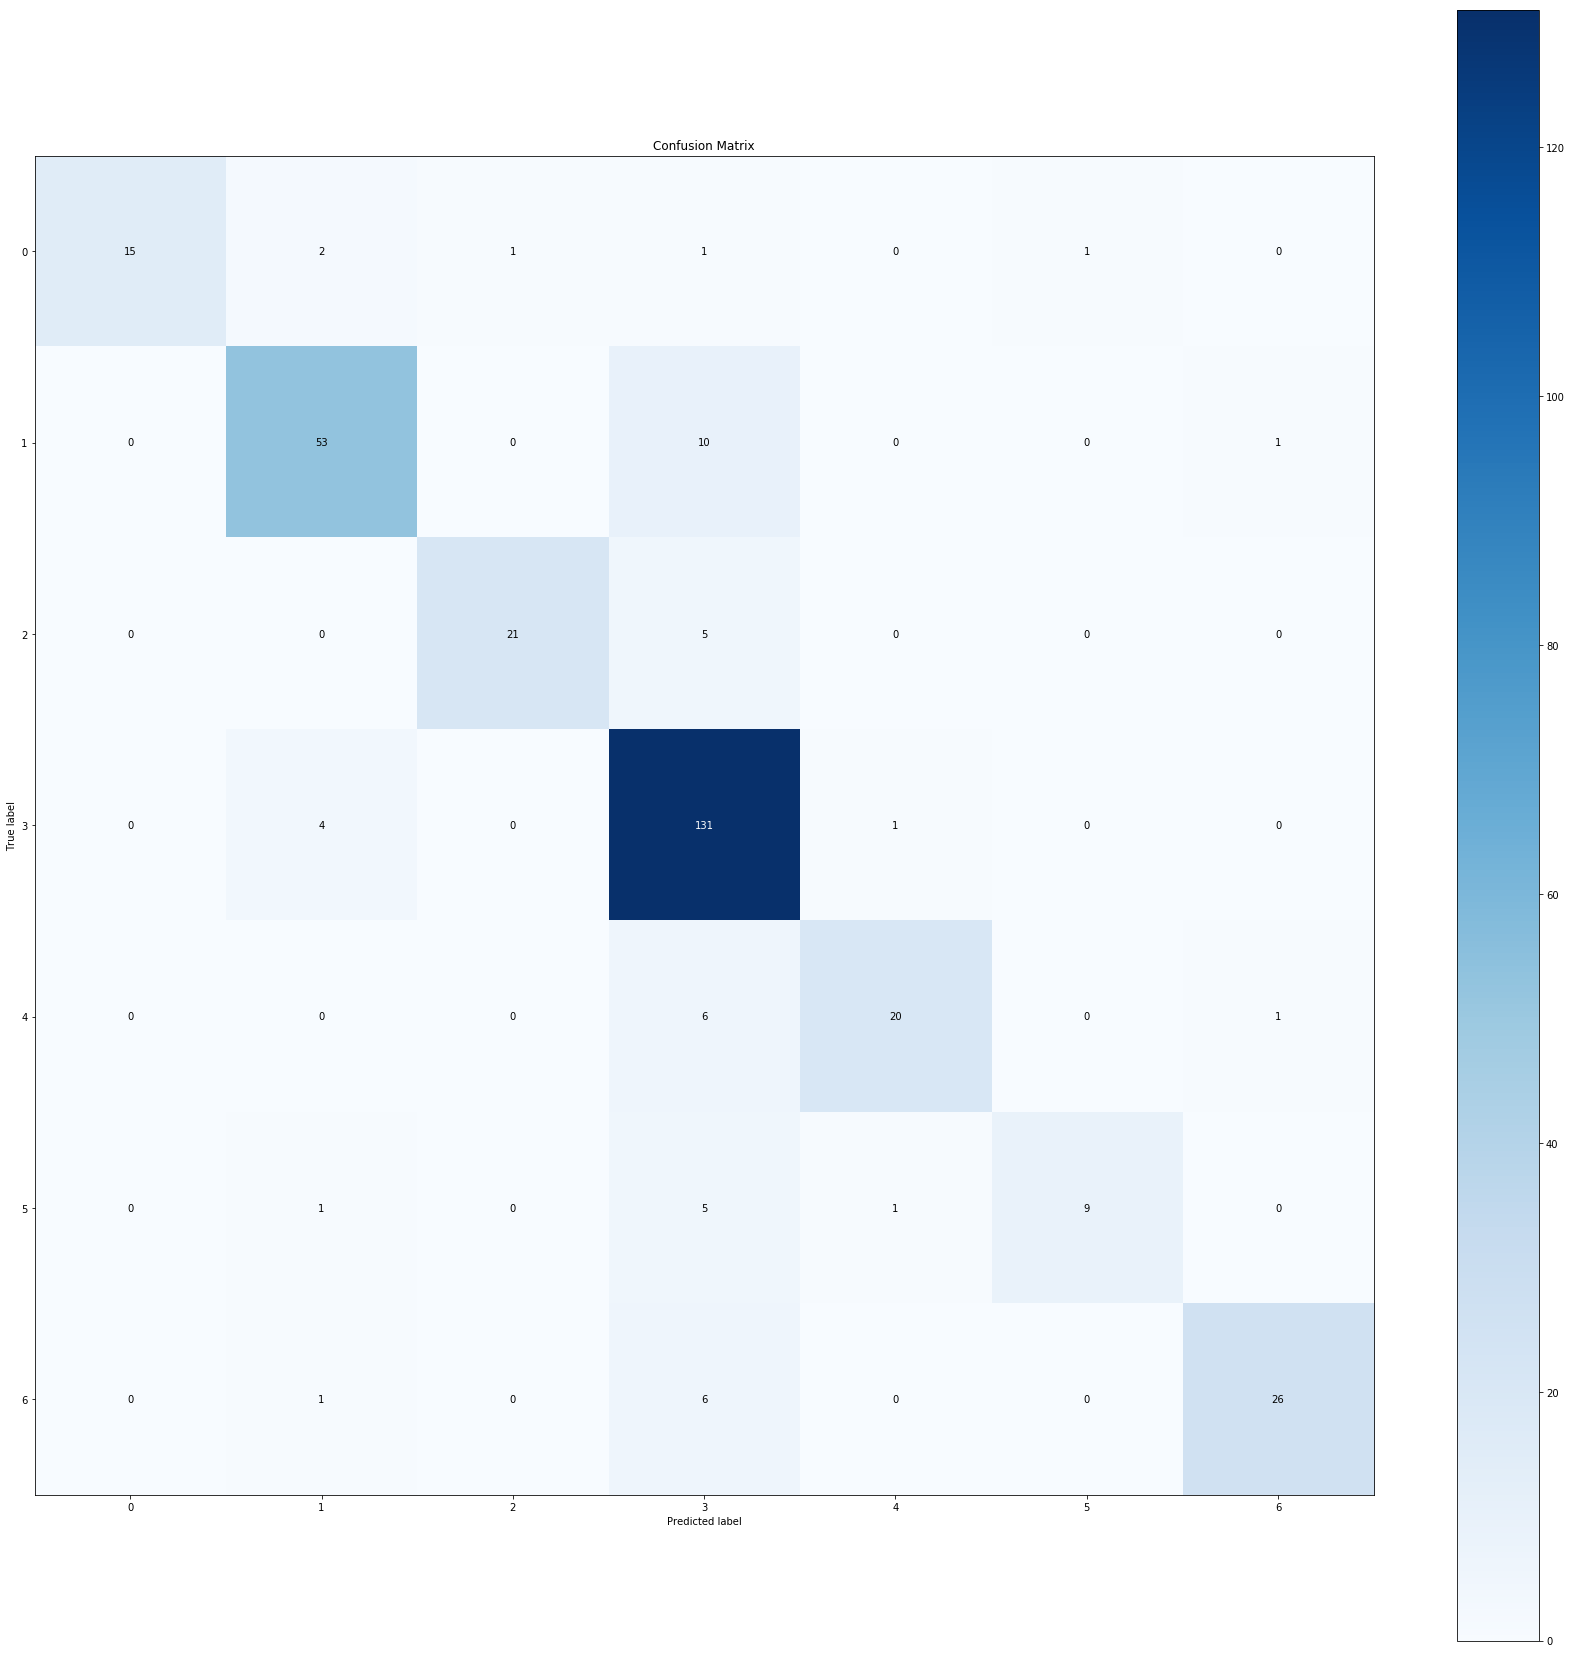

MLP  PREDICTING   
Predicting people's names on the test set
done in 0.001s
                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.65      0.74        20
     Colin Powell       0.84      0.80      0.82        64
  Donald Rumsfeld       0.77      0.77      0.77        26
    George W Bush       0.85      0.90      0.87       136
Gerhard Schroeder       0.70      0.85      0.77        27
      Hugo Chavez       0.73      0.69      0.71        16
       Tony Blair       0.82      0.70      0.75        33

      avg / total       0.82      0.82      0.82       322



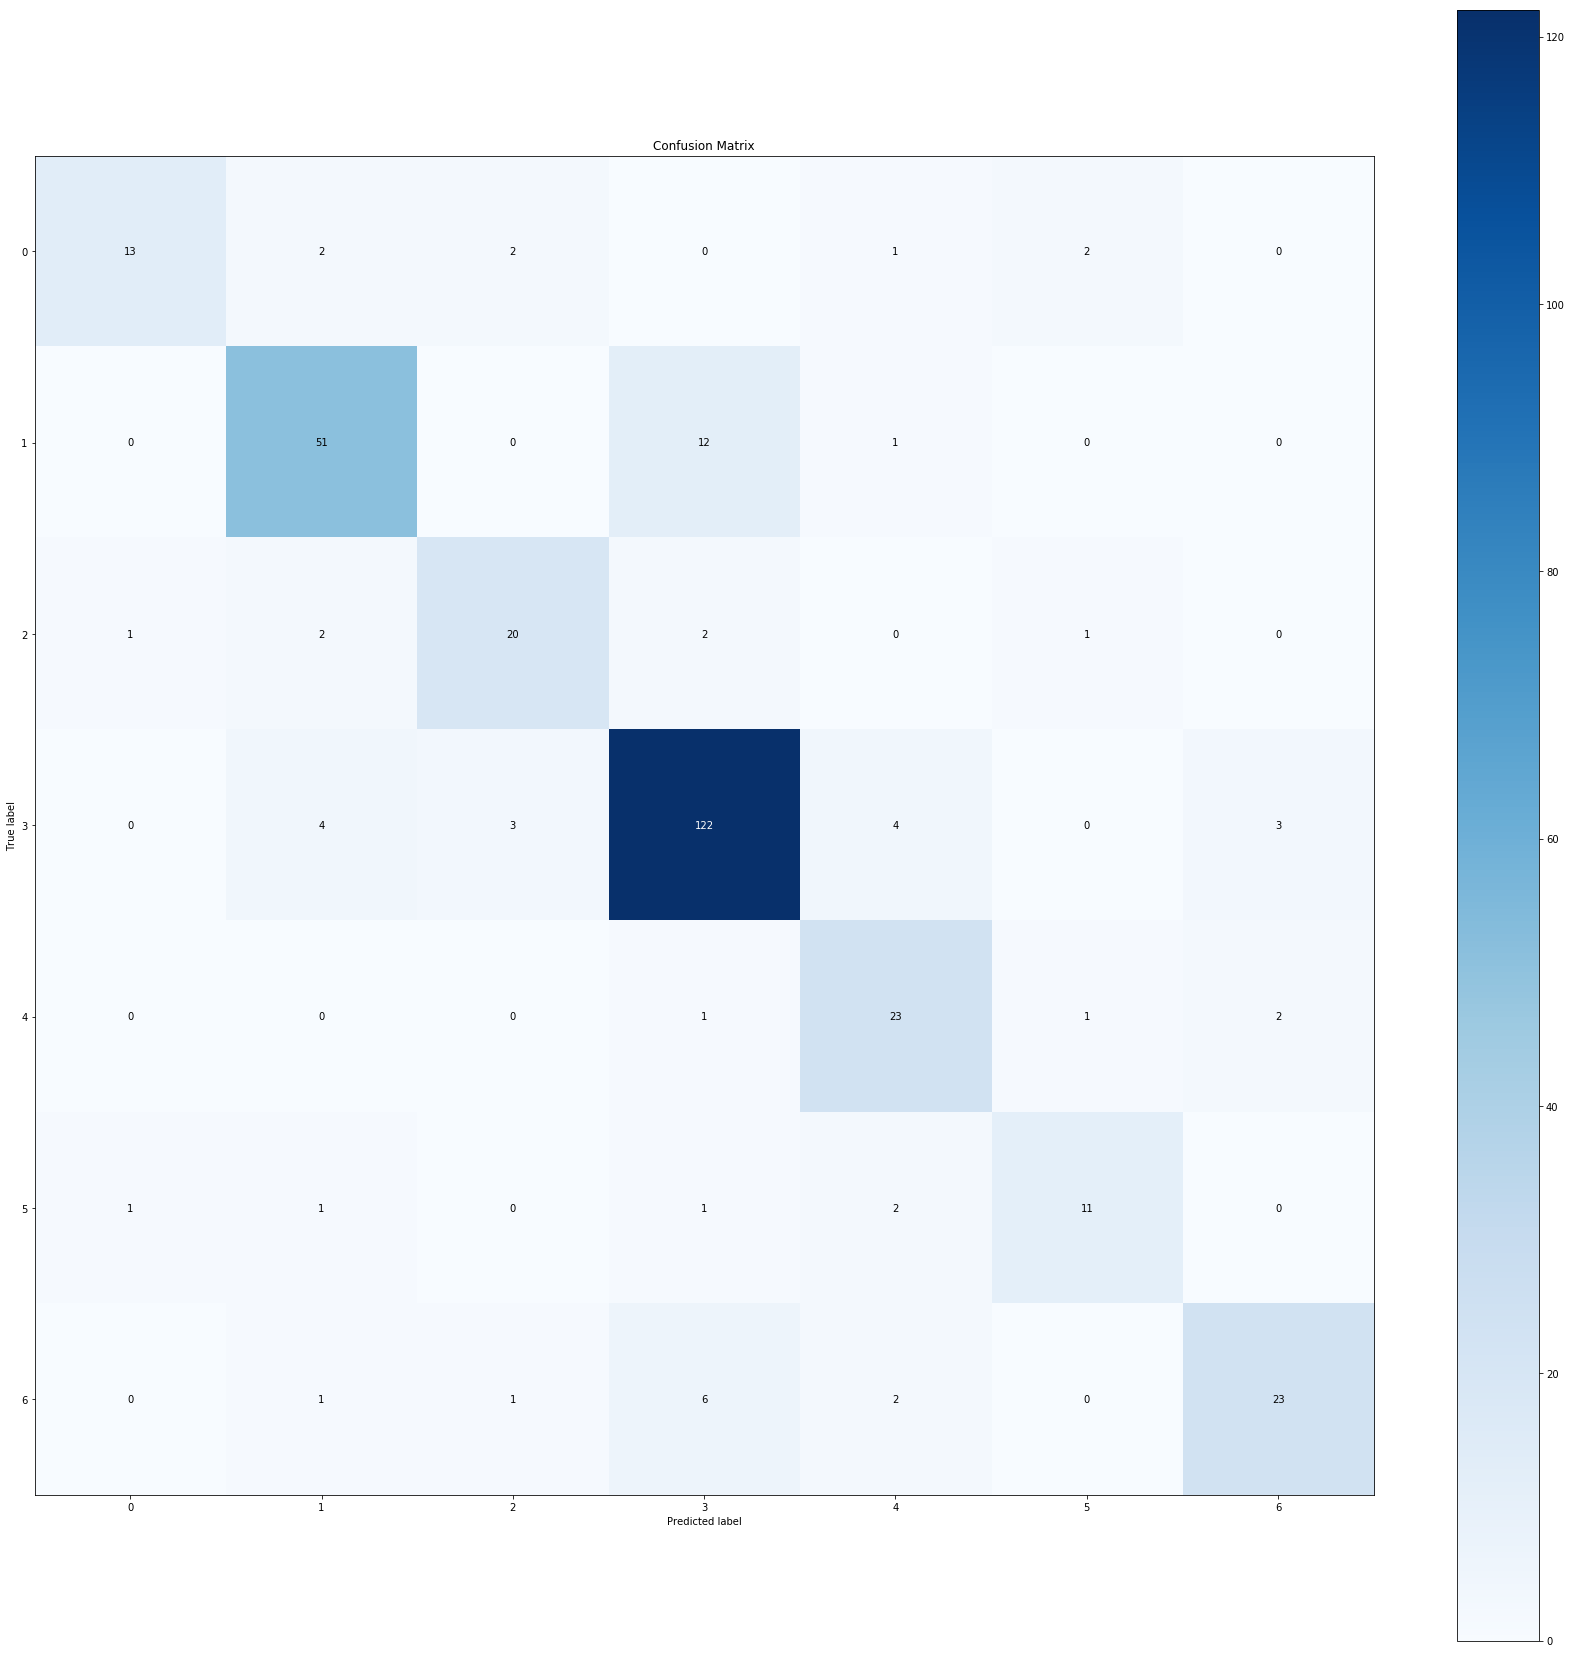

In [5]:
# Quantitative evaluation of the model quality on the test set
print("SVM  PREDICTING   ")
print("Predicting people's names on the test set")
t0 = time()
#SVM
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))


#Print Evaluation (classification report)
print(classification_report(y_test, y_pred, target_names=target_names))

#Print confusion matrix
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size
plt.show()



print("MLP  PREDICTING   ")
print("Predicting people's names on the test set")
t0 = time()
#MLP
y_pred_MLP = clf_MLP.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

#Print Evaluation (classification report)
print(classification_report(y_test, y_pred_MLP, target_names=target_names))


#Print confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_MLP, normalize=False)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size
plt.show()


Qualitative evaluation of the predictions using matplotlib SVM   
SHOW SVM


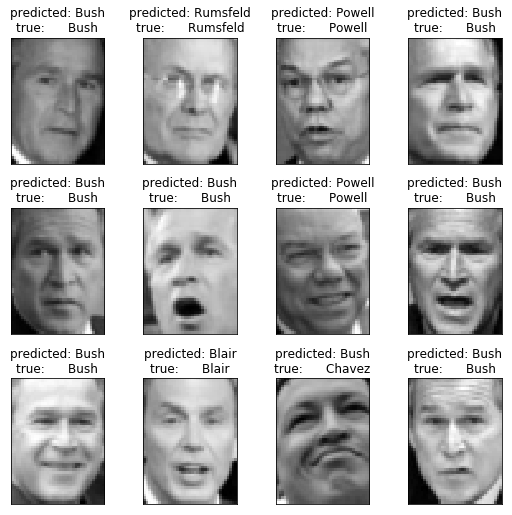

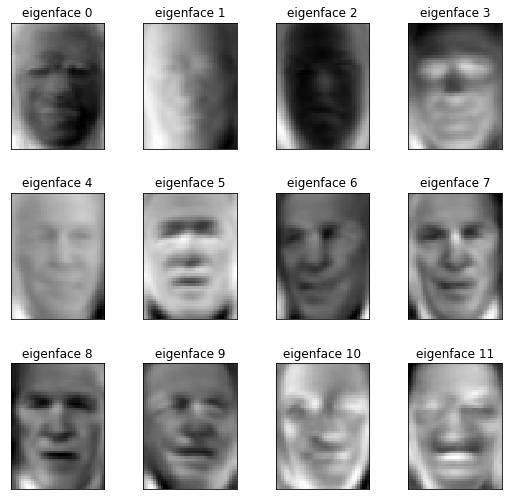

In [6]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib (SVM)
print("Qualitative evaluation of the predictions using matplotlib SVM   ")
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

print("SHOW SVM")
plt.show()

Qualitative evaluation of the predictions using matplotlib MLP   
SHOW MLP


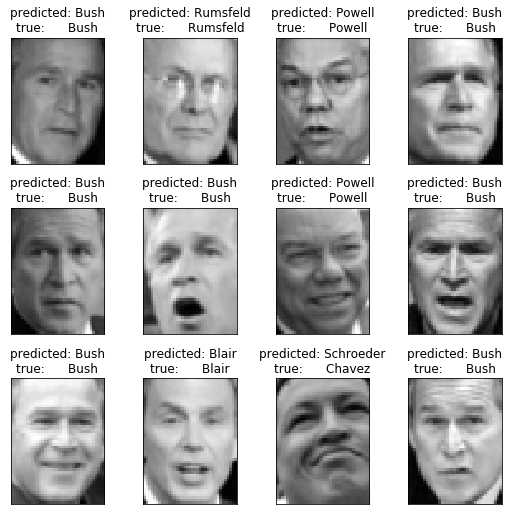

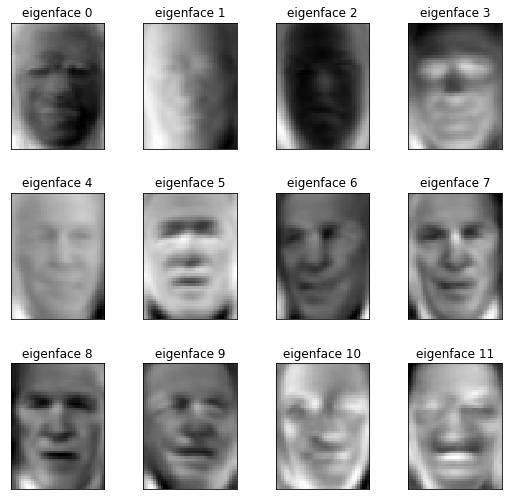

In [7]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib (MLP)
print("Qualitative evaluation of the predictions using matplotlib MLP   ")
def plot_galleryMLP(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred_MLP, y_test, target_names, i):
    pred_name = target_names[y_pred_MLP[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred_MLP, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_galleryMLP(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

print("SHOW MLP")
plt.show()